# Analyzing Hospital Provider CMS Cost Reports for FY 2014-2018

#### Jonathan Kim | March 2022

Each year, Medicare-certified hospitals and providers are required to submit an annual cost report, called the CMS-2552-10 form, to a Medicare Administrative Contractor (MAC), who will then report the data to the Healthcare Cost Report Information System (HCRIS). The Center for Medicare & Medicaid Services (CMS) compiles these data and provides a dataset that aggregates at the hospital-level, and publishes them to data.cms.gov. This project will analyze the available data for five of the most recent years - FY 2014 to 2018 - to identify trends and determine which features are most associated with hospital profitability based on these reports.

For more information on the dataset, including access to the data dictionary, please follow this link: https://www.google.com/url?q=https://data.cms.gov/provider-compliance/cost-report/hospital-provider-cost-report&sa=D&source=docs&ust=1643856557348285&usg=AOvVaw1U3H7FxmVHJrxEMdj1hgHS 

## Data Wrangling

In [1]:
import pandas as pd
# import os
# import requests
# import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats

In [2]:
# Read in CSVs
data2014 = pd.read_csv('/Users/jonathankim/Documents/Springboard/Health Project/Capstone 2 Data/Hospital_Cost_Report_2014.csv')
data2014.name = 'data2014'
data2015 = pd.read_csv('/Users/jonathankim/Documents/Springboard/Health Project/Capstone 2 Data/Hospital_Cost_Report_2015.csv')
data2015.name = 'data2015'
data2016 = pd.read_csv('/Users/jonathankim/Documents/Springboard/Health Project/Capstone 2 Data/Hospital_Cost_Report_2016.csv')
data2016.name = 'data2016'
data2017 = pd.read_csv('/Users/jonathankim/Documents/Springboard/Health Project/Capstone 2 Data/Hospital_Cost_Report_2017.csv')
data2017.name = 'data2017'
data2018 = pd.read_csv('/Users/jonathankim/Documents/Springboard/Health Project/Capstone 2 Data/Hospital_Cost_Report_2018.csv')
data2018.name = 'data2018'

/Users/jonathankim/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (105) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Find the number of rows and columns of each dataframe 
dfs = [data2014, data2015, data2016, data2017, data2018]
for df in dfs:
    print('Year',df.name[-4:],':',df.shape[0],'rows,',df.shape[1],'columns')

Year 2014 : 6250 rows, 128 columns
Year 2015 : 6257 rows, 128 columns
Year 2016 : 6211 rows, 128 columns
Year 2017 : 6172 rows, 128 columns
Year 2018 : 6156 rows, 128 columns


Are all 128 columns the same across all the datasets?

In [4]:
# Create a list of all shared column names across the datasets.
columns_shared = []
for df in dfs:
    for col in df.columns.values.tolist():
        if col not in columns_shared:
            columns_shared.append(col)

# To confirm, print whether there are any differences between the columns of each individual dataset to the shared column names.
for df in dfs:
    if len(set(columns_shared)-set(df.columns.values.tolist())) == 0:
        print('Year',df.name[-4:],'Columns :','No Differences')
    else:
        print('Year ',df.name[-4:],'Columns :',set(columns_shared)-set(df.columns.values.tolist()))

Year 2014 Columns : No Differences
Year 2015 Columns : No Differences
Year 2016 Columns : No Differences
Year 2017 Columns : No Differences
Year 2018 Columns : No Differences


All column names seem to be identical across all the datasets. 

Now, let's add a new column that simply reflects the year of that dataset, and then merge all of them into one.

In [5]:
# Extract the year for each dataset
for df in dfs:
    df['Data_Year'] = df.name[-4:]
    
# Combine all the datasets together into one dataset
hosp_orig = pd.concat(dfs,ignore_index = True, sort=False)

print('\nThe combined dataset has',hosp_orig.shape[0],'rows and',hosp_orig.shape[1],'columns.')
display(hosp_orig.head())


The combined dataset has 31046 rows and 129 columns.


,rpt_rec_num,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,...,Total Other Income,Total Income,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,Data_Year
0,549185,104075,NORTH TAMPA BEHAVIORAL SYSTEM,29910 SR 56,WESLEY CHAPEL,FL,33543,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
1,550904,514011,HIGHLAND CLARKSBUGS,3 HOSPITAL PLAZA,CLARKSBURG,WV,26301,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
2,551267,480002,GOV. JUAN F. LUIS HOSPITAL,4007 EAST DIAMOND RUBY,CHRISTIANSTED,VI,00820-4421,U. S. VIRGIN ISLANDS,99948.0,R,...,"$37,286,235","$-4,847,519",NaN,"$-4,847,519",0.573056,"$4,401,878","$22,009,389",NaN,NaN,2014
3,551467,191318,RIVERLAND MEDICAL CENTER,1700 EE WALLACE BOULEVARD NORTH,FERRIDAY,LA,71334,CONCORDIA,99919.0,R,...,"$3,358,127","$1,227,980",NaN,"$1,227,980",0.316534,"$2,926,313","$8,141,053",NaN,NaN,2014
4,551676,660001,COMMONWEALTH HEALTH CENTER,LOWER NAVY HILL RD.,SAIPAN,MP,96950,CNMI,99966.0,R,...,NaN,"$-41,490,162",NaN,"$-41,490,162",1797.044800,NaN,NaN,NaN,NaN,2014


### Explore Nulls

In [6]:
# Nulls for each column
pd.set_option('display.max_rows',500)

# Create a Null Table with Count and Percentage
hosp_null_only = pd.DataFrame(hosp_orig.isna().sum(axis=0)).rename(columns={0:'Null Count'})
hosp_null_perc_only = (hosp_null_only / hosp_orig.shape[0] *100).rename(columns={'Null Count':'Null %'})
hosp_null = hosp_null_only.merge(hosp_null_perc_only, how='left', left_index=True, right_index=True).sort_values(
    'Null Count', ascending=False)
hosp_null.index.name = "Column Name"

print('\n(Fig. 1) Null Count and Null % by Column Name')
display(hosp_null)


(Fig. 1) Null Count and Null % by Column Name


,Null Count,Null %
Column Name,,
DRG Amounts Other Than Outlier Payments,31046,100.000000
DRG Amounts for Model 4 BPCI after October 1,31014,99.896927
DRG Amounts for Model 4 BPCI before October 1,30998,99.845391
Hospital Total Days Title V For Adults &amp; Peds,30192,97.249243
Total Discharges Title V,30157,97.136507
Hospital Total Discharges Title V For Adults &amp; Peds,30157,97.136507
Total Discharges Title V + Total for all Subproviders,30149,97.110739
Total Days Title V,30119,97.014108
Total Days Title V + Total for all Subproviders,30092,96.927140


Clearly, there are many columns that have a high number of null values. But an interesting question follows: What percentage of the columns have more than, for example, 50% in nulls? To answer this question, we can simply plot the null values in a histogram, which will account for the frequencies of certain values within convenient "buckets" or "bins."

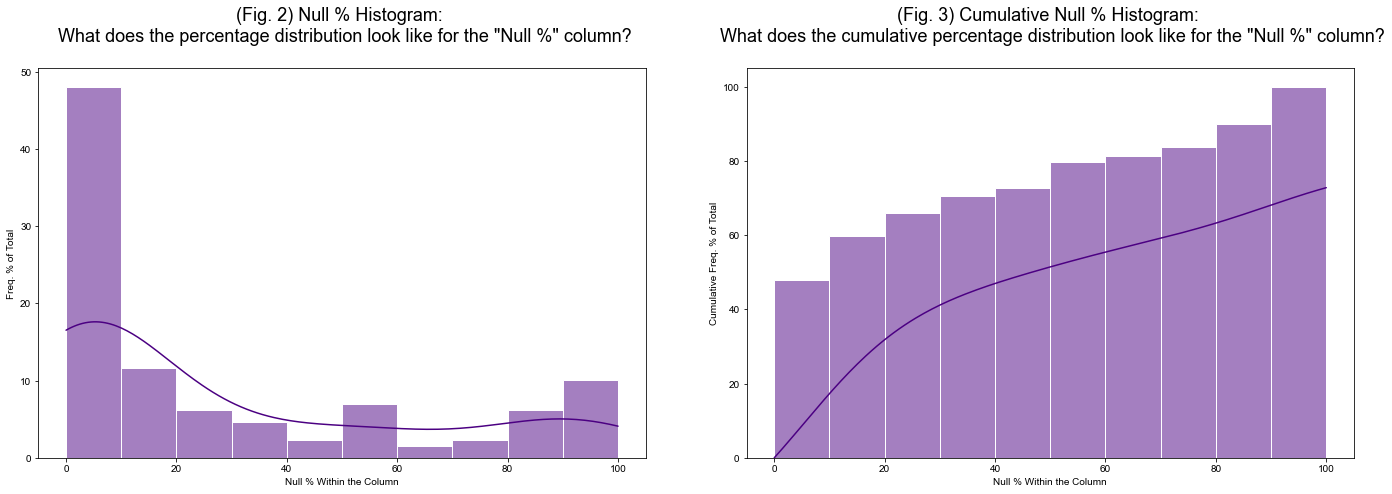

In [7]:
# Plot Histogram of Null %. What does the percentage distribution look like for "Null %" column?

fig, axes = plt.subplots(1,2, figsize=(19,6))
fig.tight_layout(w_pad=7)

sns.set(font_scale=1.5)

hist_null = sns.histplot(x='Null %', data=hosp_null, kde=True,
             binwidth=10, stat='percent', fill=True, 
             element='bars', cumulative=False, color='indigo', ax=axes[0]
            ).set_title('(Fig. 2) Null % Histogram: \n What does the percentage distribution look like for the "Null %" column?\n')

c_hist_null = sns.histplot(x='Null %', data=hosp_null, kde=True,
             binwidth=10, stat='percent', fill=True, 
             element='bars', cumulative=True, color='indigo', ax=axes[1]
            ).set_title('(Fig. 3) Cumulative Null % Histogram: \n What does the cumulative percentage distribution look like for the "Null %" column?\n')

axes[0].set_xlabel('Null % Within the Column')
axes[0].set_ylabel('Freq. % of Total')

axes[1].set_xlabel('Null % Within the Column')
axes[1].set_ylabel('Cumulative Freq. % of Total');

For context, the above histogram (Fig. 2) divides up our null data (Fig. 1) into 10 different bins, with each bin representing a particular range. Since our histogram is specifically looking at the "Null %" column, and since these percentage values can only  range in total from 0% to 100%, our null data is divided up into 10 different bins in the range from 0%-100%. This means that each bin represents a range of 10 consecutive percentage points. For example, the first bin represents 0-10%, the second bin 10-20%, etc.

In briefly analyzing our histogram, thankfully almost half of the columns have less than 10% in null values (first bin). After a drastic drop from the first to second bin, there seems to be a gradual decrease up to the sixth bin (50-60%), where an unexpected hike appears and then a buildup towards the last bin.

Due to the high percentage of columns that themselves have high amounts of null values, we unfortunately can't set an arbitrary threshold and simply remove those columns past that threshold, as this would risk the withdrawal of potentially valuable and useful columns. Instead, we will have to investigate and interpret the significance of some of the columns, and determine the best strategy for each one or as a smaller group. To start, we'll look at the last two bins - 80-90% and 90-100% - since these two see a relatively large spike in percentage frequencies, especially compared to others towards the end of the spectrum.

#### Columns with >= 80% nulls

In [8]:
# Columns with >= 80% nulls
most_hosp_null = hosp_null[hosp_null['Null %'] >= 80]

print('\nNumber of Columns with Null% >= 80% :', len(most_hosp_null))
display(most_hosp_null)


Number of Columns with Null% >= 80% : 21


,Null Count,Null %
Column Name,,
DRG Amounts Other Than Outlier Payments,31046,100.000000
DRG Amounts for Model 4 BPCI after October 1,31014,99.896927
DRG Amounts for Model 4 BPCI before October 1,30998,99.845391
Hospital Total Days Title V For Adults &amp; Peds,30192,97.249243
Total Discharges Title V,30157,97.136507
Hospital Total Discharges Title V For Adults &amp; Peds,30157,97.136507
Total Discharges Title V + Total for all Subproviders,30149,97.110739
Total Days Title V,30119,97.014108
Total Days Title V + Total for all Subproviders,30092,96.927140


Of the 22 columns with Null % >= 80%, we immediately see that the top column is completely filled with nulls; this can be automatically removed. Most of the other ones that are >=90% may have been interesting if they had fewer nulls, but none of them seem particularly important enough to keep while considering that they hardly have any non-null values, and so we will drop these as well. For the rest of the columns that are >= 80%, it's difficult to parse exactly which ones are worth keeping, but, for the sake of preserving the columns in case they could be useful later, we'll simply mark them with a binary value: 1 if non-null and 0 if null. 

This way, we can at least capture some information conveyed in these columns without the stress of finding ways to include them in our model in their absolute forms. Though, to state the obvious, we would not be able to use this binary column to analyze the diversity of non-null values within those columns, which may be an issue for columns where the diversity could matter; for example, the SCHIP revenue columns seem to vary widely (not shown above) when values exist and may represent a non-trivial portion of the applicable hospital's revenue. But again, considering that both the SCHIP revenue columns have about 84% in nulls, we will simply capture this data as 0 or 1 for now, and perhaps analyze the actual non-null values at a later time.

In [9]:
# Drop all rows with Null % >= 90
hosp_orig1 = hosp_orig[[i for i in hosp_null[hosp_null['Null %'] < 90].index.values.tolist()]]

# For columns with >= 80% and <90% nulls, convert all null to 0 and non-nulls to 1.
new_col_names = {}
hosp_orig2 = hosp_orig1.copy()
for col in hosp_null[(hosp_null['Null %'] >= 80) & (hosp_null['Null %'] < 90)].index.values.tolist():
    hosp_orig2[col] = hosp_orig2[col].astype(str).replace({'\$':''},regex=True).replace({'\,':''},regex=True).astype(float).replace(np.nan,0)
    hosp_orig2.loc[hosp_orig2[col] != 0, col] = 1
    new_col_names[col] = col + '-HIGH'
    hosp_orig2.rename(columns=new_col_names, inplace=True)

In [10]:
# Brief check if the updated columns are properly reflecting 0 and 1.

cols=[i for i in hosp_orig2.columns if '-HIGH' in i]
hosp_orig2[cols]

,Wage Related Costs for Interns and Residents-HIGH,Deferred Income-HIGH,Mortgage Payable-HIGH,Net Revenue from Stand-Alone SCHIP-HIGH,Minor Equipment Depreciable-HIGH,Wage Related Costs for Part - A Teaching Physicians-HIGH,Stand-Alone SCHIP Charges-HIGH,Total IME Payment-HIGH
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
31041,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
31042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31043,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31044,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


The above snippet doesn't display anything too out of the ordinary. Since the code seems to run okay, we'll move forward and now look into the middle four bins, from 40% to 80%, to identify which ones make sense to keep in the original, to convert to binary, or to remove entirely.

#### Columns with >= 40% and <80% nulls

In [11]:
# Columns with >= 40% and <80% nulls

middle_hosp_null = hosp_null.loc[(hosp_null['Null %'] >= 40) & (hosp_null['Null %'] < 80)]

print('\nNumber of Columns with Null% >= 40% and < 80%:', len(middle_hosp_null))
display(middle_hosp_null)


Number of Columns with Null% >= 40% and < 80%: 17


,Null Count,Null %
Column Name,,
Number of Interns and Residents (FTE),24471,78.821748
Temporary Investments,24471,78.821748
Managed Care Simulated Payments,23529,75.787541
Total Other Expenses,21368,68.826902
Payroll Taxes Payable,19504,62.822908
Investments,18462,59.466598
Notes Payable,18128,58.390775
DRG amounts before October 1,17632,56.793146
Leasehold Improvements,17281,55.662565


Let's take a quick look at the data for each of the above columns

In [12]:
hosp_orig2[[i for i in middle_hosp_null.index]]

,Number of Interns and Residents (FTE),Temporary Investments,Managed Care Simulated Payments,Total Other Expenses,Payroll Taxes Payable,Investments,Notes Payable,DRG amounts before October 1,Leasehold Improvements,Other Current Assets,Disproportionate Share Adjustment,Allowable DSH Percentage,Notes and Loans Payable (Short Term),Outlier payments for discharges,Contract Labor,DRG amounts after October 1,Fixed Equipment
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,"$12,183,108",NaN,NaN,NaN,NaN,"$218,574",NaN,NaN,"$37,367",NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,"$32,803","$152,258",NaN,NaN,NaN,NaN,NaN,NaN,"$853,287",NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,NaN,NaN,"$1,113,034",NaN,NaN,NaN,"$-42,668","$1,650,470","$2,300",NaN,"$292,301",0.3080,"$-314,660","$59,787","$68,485","$2,145,647",NaN
31042,NaN,NaN,NaN,NaN,"$71,596",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31043,NaN,NaN,NaN,NaN,NaN,"$352,737",NaN,NaN,NaN,"$468,465",NaN,NaN,"$313,184",NaN,NaN,NaN,NaN
31044,53.32,"$77,977,000","$36,608,628",NaN,NaN,NaN,NaN,"$57,782,589",NaN,"$416,000","$1,698,808",0.1176,"$13,310,000","$3,234,054","$4,657,255",NaN,NaN


Most of the above columns seem to be currencies, but due to the currency sign and commas, they are not processed as numbers. We'll remove those extraneous signs and convert the columns to float type.

In [13]:
new_col_names2 = {}
hosp_orig3 = hosp_orig2.copy()
for col in middle_hosp_null.index.values.tolist():
    hosp_orig3[col] = hosp_orig3[col].astype(str).replace({'\$':''},regex=True).replace({'\,':''},regex=True).astype(float).replace(np.nan,0)
    new_col_names2[col] = col + '-MID'
    hosp_orig3.rename(columns=new_col_names2, inplace=True)

In [14]:
mid_df = hosp_orig3[[i for i in hosp_orig3.columns if '-MID' in i]]
display(mid_df)

,Number of Interns and Residents (FTE)-MID,Temporary Investments-MID,Managed Care Simulated Payments-MID,Total Other Expenses-MID,Payroll Taxes Payable-MID,Investments-MID,Notes Payable-MID,DRG amounts before October 1-MID,Leasehold Improvements-MID,Other Current Assets-MID,Disproportionate Share Adjustment-MID,Allowable DSH Percentage-MID,Notes and Loans Payable (Short Term)-MID,Outlier payments for discharges-MID,Contract Labor-MID,DRG amounts after October 1-MID,Fixed Equipment-MID
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.0,0.0,12183108.0,0.0,0.0,0.0,0.0,218574.0,0.0,0.0000,37367.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.0,32803.0,152258.0,0.0,0.0,0.0,0.0,0.0,0.0000,853287.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,0.00,0.0,1113034.0,0.0,0.0,0.0,-42668.0,1650470.0,2300.0,0.0,292301.0,0.3080,-314660.0,59787.0,68485.0,2145647.0,0.0
31042,0.00,0.0,0.0,0.0,71596.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
31043,0.00,0.0,0.0,0.0,0.0,352737.0,0.0,0.0,0.0,468465.0,0.0,0.0000,313184.0,0.0,0.0,0.0,0.0
31044,53.32,77977000.0,36608628.0,0.0,0.0,0.0,0.0,57782589.0,0.0,416000.0,1698808.0,0.1176,13310000.0,3234054.0,4657255.0,0.0,0.0


Many of the above columns seem to include ones. Let's look a bit deeper into the percentage of ones and zeroes contained in these columns.

In [15]:
perc_list = []
for col in mid_df.columns.values.tolist():
    col_perc_list = []
    one_count = len(mid_df[mid_df[col]==1])
    zero_count = len(mid_df[mid_df[col]==0])
    total_count = len(mid_df[col])
    one_perc = round(one_count/total_count *100,2)
    zero_perc = round(zero_count/total_count *100,2)
    rem_perc = round(100 - (one_perc + zero_perc),2)
    greater_perc = round(len(mid_df[mid_df[col].abs() >100000])/total_count *100,2)
    min_value = mid_df[col].min()
    max_value = mid_df[col].max()
    mean_value = mid_df[col].mean()
    median_value = mid_df[col].median()
    col_perc_list.extend((col,one_perc,zero_perc,rem_perc, greater_perc,min_value, max_value, mean_value, median_value))
    perc_list.append(col_perc_list)

mid_perc_df = pd.DataFrame(perc_list, columns=['Column','% of 1','% of 0','% of Remainder','abs % > 100000','Min Value','Max Value','Mean','Median'])
mid_perc_df.sort_values(by='% of Remainder')

,Column,% of 1,% of 0,% of Remainder,abs % > 100000,Min Value,Max Value,Mean,Median
0,Number of Interns and Residents (FTE)-MID,0.17,78.83,21.00,0.00,0.000000e+00,1.610730e+03,1.932063e+01,0.0
1,Temporary Investments-MID,0.02,78.82,21.16,18.50,-2.379927e+08,2.212761e+09,7.331933e+06,0.0
2,Managed Care Simulated Payments-MID,0.00,75.79,24.21,23.83,-1.034400e+04,2.298970e+08,4.501643e+06,0.0
3,Total Other Expenses-MID,0.57,68.83,30.60,19.54,-4.156198e+08,1.573113e+09,1.423169e+06,0.0
4,Payroll Taxes Payable-MID,0.04,62.82,37.14,22.04,-7.126539e+07,1.396294e+08,4.178425e+05,0.0
5,Investments-MID,0.02,59.56,40.42,37.47,-7.185544e+08,7.712087e+09,3.650892e+07,0.0
6,Notes Payable-MID,0.02,58.39,41.59,38.59,-1.922281e+09,2.559901e+09,2.046163e+07,0.0
7,DRG amounts before October 1-MID,0.03,56.79,43.18,42.40,0.000000e+00,2.998640e+08,5.837705e+06,0.0
8,Leasehold Improvements-MID,0.00,55.66,44.34,37.52,-5.143884e+08,2.353442e+09,4.647183e+06,0.0
9,Other Current Assets-MID,0.06,55.11,44.83,34.54,-9.617715e+08,3.737450e+09,5.243675e+06,0.0


If hospitals are reporting \\$1 for a particular field, they are likely trying to do one of the following: 1) avoid reporting the correct amount (implying some number not equal to zero or one), 2) bypass some technical limitation wherein they aren't able to input a 0, or 3) report an actual amount of a dollar. The last option seems the most unlikely as I would assume this would very rarely be the case (e.g. one dollar spent on Investments). Given my inaccess to perfect information, I won't be able to exactly parse which of the first two options would be relevant to particular hospitals, but I'll assume that there exists *some* difference between \\$1 and \\$0, and so will move forward with the first option.

The next issue is how to reconcile these \\$1 with actual reported amounts, especially since most of the above columns  have max values that are much greater than one (with the exception of Allowable DSH Percentage-MID) and min values that are much lower than zero. Fortunately, the percentages of ones are very small compared to that of non-one and non-zeroes (% of Remainder), so we will choose to keep to keep the values in the original.

In [16]:
hosp_orig4 = hosp_orig3.copy()
hosp_orig4[[i for i in hosp_orig4.columns if '-MID' in i]]

,Number of Interns and Residents (FTE)-MID,Temporary Investments-MID,Managed Care Simulated Payments-MID,Total Other Expenses-MID,Payroll Taxes Payable-MID,Investments-MID,Notes Payable-MID,DRG amounts before October 1-MID,Leasehold Improvements-MID,Other Current Assets-MID,Disproportionate Share Adjustment-MID,Allowable DSH Percentage-MID,Notes and Loans Payable (Short Term)-MID,Outlier payments for discharges-MID,Contract Labor-MID,DRG amounts after October 1-MID,Fixed Equipment-MID
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,0.0,0.0,12183108.0,0.0,0.0,0.0,0.0,218574.0,0.0,0.0000,37367.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.0,0.0,32803.0,152258.0,0.0,0.0,0.0,0.0,0.0,0.0000,853287.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,0.00,0.0,1113034.0,0.0,0.0,0.0,-42668.0,1650470.0,2300.0,0.0,292301.0,0.3080,-314660.0,59787.0,68485.0,2145647.0,0.0
31042,0.00,0.0,0.0,0.0,71596.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0
31043,0.00,0.0,0.0,0.0,0.0,352737.0,0.0,0.0,0.0,468465.0,0.0,0.0000,313184.0,0.0,0.0,0.0,0.0
31044,53.32,77977000.0,36608628.0,0.0,0.0,0.0,0.0,57782589.0,0.0,416000.0,1698808.0,0.1176,13310000.0,3234054.0,4657255.0,0.0,0.0


Now that we verified that these mid-null columns are converted to binary, we'll move to the next batch of columns between 10-40% nulls.

#### Columns with >= 10% and < 40% nulls

In [17]:
# Columns with >= 10% and <40% nulls

low_hosp_null = hosp_null.loc[(hosp_null['Null %'] >= 10) & (hosp_null['Null %'] < 40)]

print('\nNumber of Columns with Null% >= 10% and < 40%:', len(low_hosp_null))
display(low_hosp_null)


Number of Columns with Null% >= 10% and < 40%: 29


,Null Count,Null %
Column Name,,
Wage-Related Costs (Core),12382,39.882755
Other Long Term Liabilities,12170,39.199897
Land Improvements,11556,37.222186
Total Salaries (adjusted),10567,34.036591
Less: Allowances for Uncollectible Notes and Accounts Receivable,9774,31.482317
Land,9639,31.047478
Cost of Charity Care,9123,29.385428
Net Revenue from Medicaid,8064,25.974361
Medicaid Charges,8061,25.964698


In [18]:
hosp_orig4[[i for i in low_hosp_null.index]]

,Wage-Related Costs (Core),Other Long Term Liabilities,Land Improvements,Total Salaries (adjusted),Less: Allowances for Uncollectible Notes and Accounts Receivable,Land,Cost of Charity Care,Net Revenue from Medicaid,Medicaid Charges,Other Assets,...,Hospital Total Days Title XIX For Adults &amp; Peds,Total Discharges Title XIX,Hospital Total Discharges Title XIX For Adults &amp; Peds,Total Discharges Title XIX + Total for all Subproviders,Total Days Title XIX,Major Movable Equipment,Inventory,"Salaries, Wages, and Fees Payable",Total Days Title XIX + Total for all Subproviders,Outpatient Revenue
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,"$689,166",NaN,"$-92,129,878",NaN,"$1,255,664","$4,401,878","$22,009,389","$187,357",...,3760.0,687.0,687.0,687.0,3760.0,"$29,962,004","$1,982,133","$5,105,740",3760.0,"$45,909,263"
3,NaN,NaN,"$143,910",NaN,"$-10,517,984","$116,996",NaN,"$2,926,313","$8,141,053","$136,000",...,261.0,74.0,74.0,74.0,328.0,"$6,489,874","$430,384","$1,080,022",328.0,"$26,466,851"
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,"$2,789,467","$2,692,167","$260,000","$18,198,194","$-2,430,402","$9,300,000","$2,120,514","$6,528,726","$78,607,136","$299,330",...,1054.0,195.0,195.0,208.0,1319.0,"$5,273,663","$1,938,766","$5,442,484",2218.0,"$86,716,575"
31042,NaN,"$733,388","$3,205",NaN,NaN,"$508,866",NaN,"$197,164","$223,786","$1,090,643",...,1.0,1.0,1.0,1.0,111.0,"$359,722","$81,407","$354,902",8959.0,"$1,683,618"
31043,NaN,"$143,299",NaN,NaN,NaN,NaN,$408,"$348,060","$535,477","$2,153,704",...,NaN,NaN,NaN,NaN,NaN,NaN,"$134,895","$439,661",NaN,"$7,637,780"
31044,"$61,703,354","$371,326,000",NaN,"$246,313,874",NaN,NaN,"$11,900,247","$54,043,262","$315,290,793","$234,212,000",...,5840.0,1775.0,1775.0,1775.0,8804.0,NaN,"$8,128,000","$6,582,000",8804.0,"$1,411,662,958"


All the above columns seem to indicate dollar amounts. As done previously, let's remove any potential currency signs or commas, and convert to float.

In [19]:
# For columns with >= 10% and <40% nulls, convert all null to 0 and non-nulls to 1.
new_col_names4 = {}
hosp_orig5 = hosp_orig4.copy()
for col in low_hosp_null.index.values.tolist():
    hosp_orig5[col] = hosp_orig5[col].astype(str).replace({'\$':''},regex=True).replace({'\,':''},regex=True).astype(float).replace(np.nan,0)
#     hosp_orig5[hosp_orig5[col] != 0] = 1
    new_col_names4[col] = col + '-LOW'
    hosp_orig5.rename(columns=new_col_names4, inplace=True)

In [20]:
low_df = hosp_orig5[[i for i in hosp_orig5.columns if '-LOW' in i]]
display(low_df)

,Wage-Related Costs (Core)-LOW,Other Long Term Liabilities-LOW,Land Improvements-LOW,Total Salaries (adjusted)-LOW,Less: Allowances for Uncollectible Notes and Accounts Receivable-LOW,Land-LOW,Cost of Charity Care-LOW,Net Revenue from Medicaid-LOW,Medicaid Charges-LOW,Other Assets-LOW,...,Hospital Total Days Title XIX For Adults &amp; Peds-LOW,Total Discharges Title XIX-LOW,Hospital Total Discharges Title XIX For Adults &amp; Peds-LOW,Total Discharges Title XIX + Total for all Subproviders-LOW,Total Days Title XIX-LOW,Major Movable Equipment-LOW,Inventory-LOW,"Salaries, Wages, and Fees Payable-LOW",Total Days Title XIX + Total for all Subproviders-LOW,Outpatient Revenue-LOW
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
2,0.0,0.0,689166.0,0.0,-92129878.0,0.0,1255664.0,4401878.0,22009389.0,187357.0,...,3760.0,687.0,687.0,687.0,3760.0,29962004.0,1982133.0,5105740.0,3760.0,4.590926e+07
3,0.0,0.0,143910.0,0.0,-10517984.0,116996.0,0.0,2926313.0,8141053.0,136000.0,...,261.0,74.0,74.0,74.0,328.0,6489874.0,430384.0,1080022.0,328.0,2.646685e+07
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,2789467.0,2692167.0,260000.0,18198194.0,-2430402.0,9300000.0,2120514.0,6528726.0,78607136.0,299330.0,...,1054.0,195.0,195.0,208.0,1319.0,5273663.0,1938766.0,5442484.0,2218.0,8.671658e+07
31042,0.0,733388.0,3205.0,0.0,0.0,508866.0,0.0,197164.0,223786.0,1090643.0,...,1.0,1.0,1.0,1.0,111.0,359722.0,81407.0,354902.0,8959.0,1.683618e+06
31043,0.0,143299.0,0.0,0.0,0.0,0.0,408.0,348060.0,535477.0,2153704.0,...,0.0,0.0,0.0,0.0,0.0,0.0,134895.0,439661.0,0.0,7.637780e+06
31044,61703354.0,371326000.0,0.0,246313874.0,0.0,0.0,11900247.0,54043262.0,315290793.0,234212000.0,...,5840.0,1775.0,1775.0,1775.0,8804.0,0.0,8128000.0,6582000.0,8804.0,1.411663e+09


Using the same methodology as the mid-null columns, we'll explore these low-null columns a bit more.

In [21]:
perc_list2 = []
for col in low_df.columns.values.tolist():
    col_perc_list = []
    one_count = len(low_df[low_df[col]==1])
    zero_count = len(low_df[low_df[col]==0])
    total_count = len(low_df[col])
    one_perc = round(one_count/total_count *100,2)
    zero_perc = round(zero_count/total_count *100,2)
    rem_perc = round(100 - (one_perc + zero_perc),2)
    greater_perc = round(len(low_df[low_df[col].abs() >100000])/total_count *100,2)
    min_value = low_df[col].min()
    max_value = low_df[col].max()
    mean_value = low_df[col].mean()
    median_value = low_df[col].median()
    col_perc_list.extend((col,one_perc,zero_perc,rem_perc, greater_perc,min_value, max_value, mean_value, median_value))
    perc_list2.append(col_perc_list)

low_perc_df = pd.DataFrame(perc_list2, columns=['Column','% of 1','% of 0','% of Remainder','abs % > 100000','Min Value','Max Value','Mean','Median'])
low_perc_df.sort_values(by='% of Remainder')

,Column,% of 1,% of 0,% of Remainder,abs % > 100000,Min Value,Max Value,Mean,Median
0,Wage-Related Costs (Core)-LOW,0.41,39.88,59.71,59.47,0.000000e+00,2.441430e+09,1.241654e+07,1.912158e+06
1,Other Long Term Liabilities-LOW,0.07,39.20,60.73,54.60,-2.310101e+09,5.158781e+09,2.565158e+07,1.663030e+05
2,Land Improvements-LOW,0.03,37.22,62.75,55.99,-3.577858e+08,9.094468e+08,2.344269e+06,2.465625e+05
3,Total Salaries (adjusted)-LOW,0.01,34.04,65.95,65.95,0.000000e+00,2.748795e+09,5.228449e+07,1.234069e+07
4,Less: Allowances for Uncollectible Notes and A...,0.00,31.48,68.52,67.25,-3.652290e+09,2.755657e+08,-2.685100e+07,-2.070290e+06
5,Land-LOW,0.03,31.05,68.92,59.80,-1.621611e+07,1.234399e+09,4.769913e+06,3.640730e+05
6,Cost of Charity Care-LOW,0.00,29.39,70.61,54.65,-1.576980e+05,7.579931e+08,3.029719e+06,1.734915e+05
7,Net Revenue from Medicaid-LOW,0.01,25.97,74.02,72.38,-2.691952e+07,3.114405e+10,1.723762e+07,2.741648e+06
8,Medicaid Charges-LOW,0.00,25.96,74.04,73.47,-4.686500e+05,4.732927e+09,9.100114e+07,1.121226e+07
9,Other Assets-LOW,0.13,25.13,74.74,65.37,-1.850592e+09,8.379705e+09,2.449783e+07,8.768080e+05


Since the majority of the values for the above columns are non-one and non-zeroes, we will choose to keep them in their original form. 

In [22]:
hosp_orig6 = hosp_orig5.copy()

#### Columns with > 0% and < 10% nulls

In [23]:
# Columns with < 10% nulls
ten_hosp_null = hosp_null.loc[(hosp_null['Null %'] < 10) & (hosp_null['Null %'] > 0)]

print('\nNumber of Columns with Null% <10% and >0%:', len(ten_hosp_null))
display(ten_hosp_null)


Number of Columns with Null% <10% and >0%: 50


,Null Count,Null %
Column Name,,
Outpatient Total Charges,2847,9.170263
Cash on Hand and in Banks,2471,7.959157
Accounts Payable,1862,5.997552
Accounts Receivable,1796,5.784964
Total fixed Assets,1734,5.585261
Total Other Income,1701,5.478967
Less Contractual Allowance and discounts on patients' accounts,1639,5.279263
Total Current Liabilities,1524,4.908845
Total Liabilities,1504,4.844424


In [24]:
hosp_orig6_ten = hosp_orig6[[i for i in ten_hosp_null.index]]
hosp_orig6_ten

,Outpatient Total Charges,Cash on Hand and in Banks,Accounts Payable,Accounts Receivable,Total fixed Assets,Total Other Income,Less Contractual Allowance and discounts on patients' accounts,Total Current Liabilities,Total Liabilities,Total Current Assets,...,Total Bed Days Available + Total for all Subproviders,Number of Beds + Total for all Subproviders,Combined Outpatient + Inpatient Total Charges,Net Income from Service to Patients,Rural Versus Urban,Medicare CBSA Number,Total Costs,Less Total Operating Expense,Overhead Non-Salary Costs,Street Address
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29910 SR 56
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 HOSPITAL PLAZA
2,"$45,594,791","$2,534,569","$24,927,666","$102,951,888","$35,891,329","$37,286,235","$97,522,794","$52,580,725","$52,580,725","$7,225,840",...,40880.0,112.0,"$129,652,291","$-42,133,754",R,99948.0,"$74,298,056","$74,263,251",$39629563,4007 EAST DIAMOND RUBY
3,"$26,435,402","$2,076,465","$999,786","$13,666,861","$2,505,051","$3,358,127","$31,755,881","$2,965,898","$2,965,898","$5,797,232",...,9176.0,25.0,"$43,936,576","$-2,130,147",R,99919.0,"$13,907,419","$15,435,567",$8772769,1700 EE WALLACE BOULEVARD NORTH
4,"$11,000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27010.0,74.0,"$25,000","$-41,490,162",R,99966.0,"$44,926,120","$41,490,162",$20761420,LOWER NAVY HILL RD.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,"$86,716,576","$-1,903,584","$3,384,628","$19,617,834","$21,954,274","$1,081,580","$170,715,026","$8,619,263","$117,285,085","$18,005,784",...,33338.0,158.0,"$198,850,280","$-12,071,926",U,16974.0,"$34,745,411","$40,207,178",$22008984,1225 SUPERIOR STREET
31042,"$1,683,303","$822,494","$446,991","$824,593","$1,022,831","$1,801,732","$22,499","$1,066,793","$1,800,181","$2,113,190",...,21170.0,58.0,"$5,945,893","$-1,109,896",R,99935.0,"$6,030,642","$7,034,993",$4041820,200 NORTH MAIN STREET
31043,"$7,635,318","$3,113,009","$276,557","$592,595","$4,174,373","$1,488,539","$826,727","$1,210,818","$2,539,945","$4,622,289",...,7300.0,20.0,"$8,898,392","$-667,175",R,99935.0,"$7,986,343","$8,738,815",$5051829,909 SECOND STREET
31044,"$1,410,864,378","$109,904,000","$65,461,000","$119,082,000","$327,023,000","$85,989,605","$2,029,816,000","$95,433,000","$466,759,000","$357,005,000",...,179945.0,493.0,"$2,772,598,531","$-6,088,605",U,43900.0,"$690,664,225","$748,869,401",$496950622,101 E WOOD ST


From a glance of the list of columns above, only two seem blatantly not to indicate a number value: "County" and "Street Address." However, there is one column that's a bit ambiguous: "Rural Versus Urban." Let's quickly look into the values of this column.

In [25]:
# hosp_orig6_ten_sub_test = hosp_orig6_ten.loc[:,(hosp_orig6_ten == 'R').any()]
# hosp_orig6_ten_sub_test[(~hosp_orig6_ten_sub_test['Rural Versus Urban'].isna()) & (hosp_orig6_ten_sub_test['Rural Versus Urban'].str.contains('U'))]

In [26]:
# Find the unique values of the Rural Versus Urban column
print(hosp_orig6_ten['Rural Versus Urban'].unique())

[nan 'R' 'U']


The "Rural Versus Urban" column is a combination of NaN, number, and strings. Unfortunately, we don't have much context around whether the meaning of the one value; is it supposed to represent a 'R' or 'U'? Due to this lack of context, we will have to remove this column from our dataset.

For the "County" and "Street Address" columns as identified previously, we can keep these in the dataset, but exclude them from the for-loop when removing the dollar sign and commas.

The rest of the columns look to represent a number, whether by the count or amount of something. We'll replace the dollar sign and commas for these columns to at least cover the ones that do have those characters, since the output will be a conversion to float type anyways.

In [27]:
# Remove the Rural Versus Urban column from the dataset.
hosp_orig7 = hosp_orig6.loc[:, (hosp_orig6.columns != 'Rural Versus Urban')]

# Remove the County and Street Address columns from the list of columns for use in the for-loop.
hosp_orig6_ten2 = hosp_orig6_ten.loc[:, (hosp_orig6_ten.columns != 'County') & \
                               (hosp_orig6_ten.columns != 'Street Address') & \
                               (hosp_orig6_ten.columns != 'Rural Versus Urban')]
hosp_orig7.columns

Index(['Wage Related Costs for Interns and Residents-HIGH',
       'Deferred Income-HIGH', 'Mortgage Payable-HIGH',
       'Net Revenue from Stand-Alone SCHIP-HIGH',
       'Minor Equipment Depreciable-HIGH',
       'Wage Related Costs for Part - A Teaching Physicians-HIGH',
       'Stand-Alone SCHIP Charges-HIGH', 'Total IME Payment-HIGH',
       'Number of Interns and Residents (FTE)-MID',
       'Temporary Investments-MID',
       ...
       'Fiscal Year End Date', 'Fiscal Year Begin Date', 'Type of Control',
       'Provider Type', 'CCN Facility Type', 'Zip Code', 'State Code', 'City',
       'Hospital Name', 'Data_Year'],
      dtype='object', length=115)

We can verify that the three columns have been successfully removed. Now we can remove the dollar sign and commas.

In [28]:
# For columns with >= 10% and <40% nulls, convert all null to 0 and non-nulls to 1.
new_col_names5 = {}
hosp_orig8 = hosp_orig7.copy()
for col in hosp_orig6_ten2.columns.values.tolist():
    hosp_orig8[col] = hosp_orig8[col].astype(str).replace({'\$':''},regex=True).replace({'\,':''},regex=True) \
                .astype(float).replace(np.nan,0)
    new_col_names5[col] = col + '-L10'
    hosp_orig8.rename(columns=new_col_names5, inplace=True)

In [29]:
low10_df = hosp_orig8[[i for i in hosp_orig8.columns if '-L10' in i]]
display(low10_df)

,Outpatient Total Charges-L10,Cash on Hand and in Banks-L10,Accounts Payable-L10,Accounts Receivable-L10,Total fixed Assets-L10,Total Other Income-L10,Less Contractual Allowance and discounts on patients' accounts-L10,Total Current Liabilities-L10,Total Liabilities-L10,Total Current Assets-L10,...,Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders-L10,Total Salaries From Worksheet A-L10,Total Bed Days Available + Total for all Subproviders-L10,Number of Beds + Total for all Subproviders-L10,Combined Outpatient + Inpatient Total Charges-L10,Net Income from Service to Patients-L10,Medicare CBSA Number-L10,Total Costs-L10,Less Total Operating Expense-L10,Overhead Non-Salary Costs-L10
0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0
2,4.559479e+07,2534569.0,24927666.0,102951888.0,35891329.0,37286235.0,9.752279e+07,52580725.0,52580725.0,7225840.0,...,21658.0,34633688.0,40880.0,112.0,1.296523e+08,-42133754.0,99948.0,74298056.0,74263251.0,39629563.0
3,2.643540e+07,2076465.0,999786.0,13666861.0,2505051.0,3358127.0,3.175588e+07,2965898.0,2965898.0,5797232.0,...,4358.0,6662798.0,9176.0,25.0,4.393658e+07,-2130147.0,99919.0,13907419.0,15435567.0,8772769.0
4,1.100000e+04,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,...,19017.0,20728742.0,27010.0,74.0,2.500000e+04,-41490162.0,99966.0,44926120.0,41490162.0,20761420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,8.671658e+07,-1903584.0,3384628.0,19617834.0,21954274.0,1081580.0,1.707150e+08,8619263.0,117285085.0,18005784.0,...,14152.0,18198194.0,33338.0,158.0,1.988503e+08,-12071926.0,16974.0,34745411.0,40207178.0,22008984.0
31042,1.683303e+06,822494.0,446991.0,824593.0,1022831.0,1801732.0,2.249900e+04,1066793.0,1800181.0,2113190.0,...,17412.0,2993173.0,21170.0,58.0,5.945893e+06,-1109896.0,99935.0,6030642.0,7034993.0,4041820.0
31043,7.635318e+06,3113009.0,276557.0,592595.0,4174373.0,1488539.0,8.267270e+05,1210818.0,2539945.0,4622289.0,...,7612.0,3662555.0,7300.0,20.0,8.898392e+06,-667175.0,99935.0,7986343.0,8738815.0,5051829.0
31044,1.410864e+09,109904000.0,65461000.0,119082000.0,327023000.0,85989605.0,2.029816e+09,95433000.0,466759000.0,357005000.0,...,222761.0,251918779.0,179945.0,493.0,2.772599e+09,-6088605.0,43900.0,690664225.0,748869401.0,496950622.0


Let's quickly analyze the % of ones, zeroes, etc (like the ones before) to help determine if any of the columns have too high percentages for ones and/or zeroes.

In [30]:
perc_list3 = []
for col in low10_df.columns.values.tolist():
    col_perc_list = []
    one_count = len(low10_df[low10_df[col]==1])
    zero_count = len(low10_df[low10_df[col]==0])
    total_count = len(low10_df[col])
    one_perc = round(one_count/total_count *100,2)
    zero_perc = round(zero_count/total_count *100,2)
    rem_perc = round(100 - (one_perc + zero_perc),2)
    greater_perc = round(len(low10_df[low10_df[col].abs() >100000])/total_count *100,2)
    min_value = low10_df[col].min()
    max_value = low10_df[col].max()
    mean_value = low10_df[col].mean()
    median_value = low10_df[col].median()
    col_perc_list.extend((col,one_perc,zero_perc,rem_perc, greater_perc,min_value, max_value, mean_value, median_value))
    perc_list3.append(col_perc_list)

low10_perc_df = pd.DataFrame(perc_list3, columns=['Column','% of 1','% of 0','% of Remainder','abs % > 100000','Min Value','Max Value','Mean','Median'])
low10_perc_df.sort_values(by='% of Remainder')

,Column,% of 1,% of 0,% of Remainder,abs % > 100000,Min Value,Max Value,Mean,Median
0,Outpatient Total Charges-L10,0.00,9.17,90.83,87.91,0.000000e+00,1.290112e+10,2.530833e+08,6.670987e+07
1,Cash on Hand and in Banks-L10,0.02,7.96,92.02,72.28,-2.512770e+09,4.076539e+09,1.376697e+07,8.224645e+05
2,Accounts Payable-L10,0.01,6.00,93.99,90.84,-1.463269e+09,2.057275e+09,9.518210e+06,1.825774e+06
3,Accounts Receivable-L10,0.00,5.78,94.22,93.93,-1.780458e+08,3.711121e+09,5.015134e+07,1.116200e+07
4,Total fixed Assets-L10,0.00,5.59,94.41,93.47,-5.537870e+08,5.626475e+09,8.012690e+07,1.866865e+07
5,Total Other Income-L10,0.01,5.48,94.51,82.71,-2.211753e+09,1.921048e+09,1.315895e+07,1.731000e+06
6,Less Contractual Allowance and discounts on pa...,0.06,5.28,94.66,94.37,-1.129991e+09,1.735686e+10,3.995599e+08,7.060578e+07
7,Total Current Liabilities-L10,0.02,4.91,95.07,94.39,-1.636689e+09,6.397619e+09,3.191935e+07,6.578713e+06
8,Total Liabilities-L10,0.04,4.84,95.12,94.64,-2.844638e+09,6.602518e+09,8.573764e+07,1.505777e+07
9,Total Current Assets-L10,0.05,4.73,95.22,95.01,-1.524193e+09,6.193218e+09,6.744872e+07,1.331128e+07


It looks like the vast majority of the values for each of these columns are non-one and non-zero values. We can keep these as-is!

In [31]:
print(len(hosp_orig8))

31046


In [32]:
hosp_orig8

,Wage Related Costs for Interns and Residents-HIGH,Deferred Income-HIGH,Mortgage Payable-HIGH,Net Revenue from Stand-Alone SCHIP-HIGH,Minor Equipment Depreciable-HIGH,Wage Related Costs for Part - A Teaching Physicians-HIGH,Stand-Alone SCHIP Charges-HIGH,Total IME Payment-HIGH,Number of Interns and Residents (FTE)-MID,Temporary Investments-MID,...,Fiscal Year End Date,Fiscal Year Begin Date,Type of Control,Provider Type,CCN Facility Type,Zip Code,State Code,City,Hospital Name,Data_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,2013-12-30,2013-11-21,4,2,PH,33543,FL,WESLEY CHAPEL,NORTH TAMPA BEHAVIORAL SYSTEM,2014
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,2014-09-29,2013-09-30,3,2,PH,26301,WV,CLARKSBURG,HIGHLAND CLARKSBUGS,2014
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,...,2014-09-29,2013-09-30,13,1,STH,00820-4421,VI,CHRISTIANSTED,GOV. JUAN F. LUIS HOSPITAL,2014
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,2014-09-29,2013-09-30,11,1,CAH,71334,LA,FERRIDAY,RIVERLAND MEDICAL CENTER,2014
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,2014-09-29,2013-09-30,13,1,STH,96950,MP,SAIPAN,COMMONWEALTH HEALTH CENTER,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31041,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,...,2019-01-26,2018-06-30,4,4,STH,60160,IL,MELROSE PARK,WESTLAKE COMMUNITY HOSPITAL,2018
31042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,2019-06-29,2018-06-30,2,2,CAH,58254-,ND,MCVILLE,NELSON COUNTY HEALTH SYSTEM-HOSPITAL,2018
31043,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,2019-06-29,2018-06-30,2,2,CAH,58249,ND,LANGDON,CAVALIER COUNTY MEMORIAL HOSPITAL,2018
31044,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,53.32,77977000.0,...,2018-09-29,2017-09-30,9,5,STH,29303-,SC,SPARTANBURG,SPARTANBURG REGIONAL MEDICAL CENTER,2018


As a final measure, let's look at the columns that typically serve as "identifiers" or basic information about the hospitals, and see if any of these have strange values. Note that these columns are subjectively determined. There may be more that were missed, but these should cover enough to gauge a clear picture.

In [33]:
basic_id_info = ['Street Address','rpt_rec_num','Provider CCN',\
                 'Fiscal Year End Date','Fiscal Year Begin Date','Type of Control',\
                 'Provider Type','CCN Facility Type','Zip Code','State Code','City','Hospital Name','County']

for info in basic_id_info:
    print(info)
    print('# of Ones', ': ', len(hosp_orig8.loc[hosp_orig8[info]=='1']))
    print('# of Zeros', ': ', len(hosp_orig8.loc[hosp_orig8[info]=='0']))
    print('# of Nulls', ': ', len(hosp_orig8.loc[hosp_orig8[info].isnull()]),'\n')
    

Street Address
# of Ones :  2
# of Zeros :  0
# of Nulls :  23 

rpt_rec_num
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Provider CCN
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Fiscal Year End Date
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Fiscal Year Begin Date
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Type of Control
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Provider Type
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

CCN Facility Type
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Zip Code
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

State Code
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

City
# of Ones :  0
# of Zeros :  0
# of Nulls :  0 

Hospital Name
# of Ones :  1
# of Zeros :  0
# of Nulls :  0 

County
# of Ones :  0
# of Zeros :  0
# of Nulls :  1338 



There are only three columns that have at least one count for having a 0, 1 or null: Street Address, County, and Hospital Name. The first two are the usual suspects; we encountered them before and we decided to keep them in their original values. The last column - Hospital Name - only has one instance where a value is one, but we'll choose to keep this row since 1) the other columns in the rest of the dataset has already been vetted, 2) we will likely not be analyzing too deeply at the individual hospital level, and 3) one row won't massively affect our outcome.

Our dataset is now ready for the next phase!

In [34]:
hosp_final = hosp_orig8.copy()

In [35]:
hosp_final.head()

,Wage Related Costs for Interns and Residents-HIGH,Deferred Income-HIGH,Mortgage Payable-HIGH,Net Revenue from Stand-Alone SCHIP-HIGH,Minor Equipment Depreciable-HIGH,Wage Related Costs for Part - A Teaching Physicians-HIGH,Stand-Alone SCHIP Charges-HIGH,Total IME Payment-HIGH,Number of Interns and Residents (FTE)-MID,Temporary Investments-MID,...,Fiscal Year End Date,Fiscal Year Begin Date,Type of Control,Provider Type,CCN Facility Type,Zip Code,State Code,City,Hospital Name,Data_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2013-12-30,2013-11-21,4,2,PH,33543,FL,WESLEY CHAPEL,NORTH TAMPA BEHAVIORAL SYSTEM,2014
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2014-09-29,2013-09-30,3,2,PH,26301,WV,CLARKSBURG,HIGHLAND CLARKSBUGS,2014
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2014-09-29,2013-09-30,13,1,STH,00820-4421,VI,CHRISTIANSTED,GOV. JUAN F. LUIS HOSPITAL,2014
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2014-09-29,2013-09-30,11,1,CAH,71334,LA,FERRIDAY,RIVERLAND MEDICAL CENTER,2014
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2014-09-29,2013-09-30,13,1,STH,96950,MP,SAIPAN,COMMONWEALTH HEALTH CENTER,2014


## Exploratory Data Analysis (EDA)

The current strategy for this EDA section is to explore the features and identify ones that could be useful for modelling, such as regression analyses.

We will set the column "Net Income" as the dependent (or prediction) variable, and compare the the other columns with this one.

### Distribution of "Net Income"

In [36]:
# Basic stats for Net Income
hosp_final['Net Income-L10'].describe()

count    3.104600e+04
mean     6.783494e+06
std      7.351853e+07
min     -1.586455e+09
25%     -7.880822e+05
50%      1.249522e+06
75%      9.222020e+06
max      5.350317e+09
Name: Net Income-L10, dtype: float64

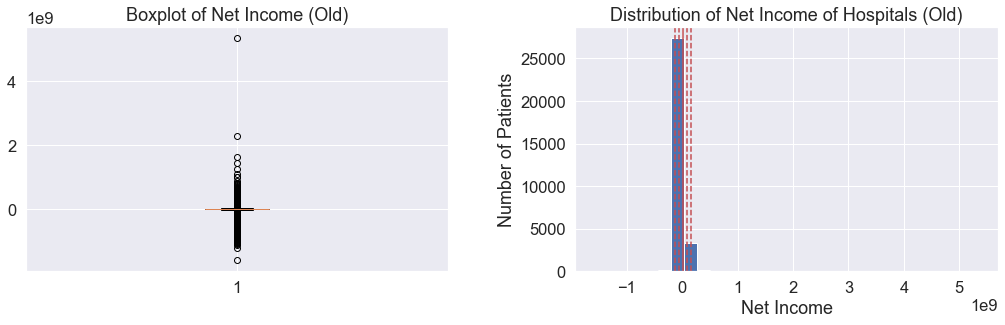

In [37]:
# Plot boxplot and histogram for Net Income.

fig, axs = plt.subplots(1,2, figsize=(15,4))
net_income = hosp_final['Net Income-L10']

# Boxplot of Net Income
axs[0].boxplot(net_income)
axs[0].set_title('Boxplot of Net Income (Old)')

# Histogram of Net Income
axs[1].hist(net_income, bins=30)
_ = plt.xlabel('Net Income')
_ = plt.ylabel('Number of Patients')
_ = plt.title('Distribution of Net Income of Hospitals (Old)')
_ = plt.axvline(np.mean(net_income),color='r')
_ = plt.axvline(np.mean(net_income) + np.std(net_income), color='r', linestyle='--')
_ = plt.axvline(np.mean(net_income) - np.std(net_income), color='r', linestyle='--')
_ = plt.axvline(np.mean(net_income) + (2*np.std(net_income)), color='r', linestyle='--')
_ = plt.axvline(np.mean(net_income) - (2*np.std(net_income)), color='r', linestyle='--')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

plt.show()

It looks like there's very high outliers that are distorting both the boxplot and histogram. Let's remove these based on whether the absolute value of the z-score is greater (or equal) to 5. This means that we'll only keep Net Incomes whose standard deviations are less than five from the mean.

Though there are risks of removing outliers, as they can provide useful information, we'll remove them in this analysis to ensure that the outliers don't needlessly skew the predictive models.

In [38]:
# New df that filters for Net Income less than 3 standard deviations from the mean.
hosp_final_z = hosp_final[(np.abs(stats.zscore(hosp_final['Net Income-L10'])) < 5)]


Let's run another boxplot and histogram on the newly filtered dataset. 

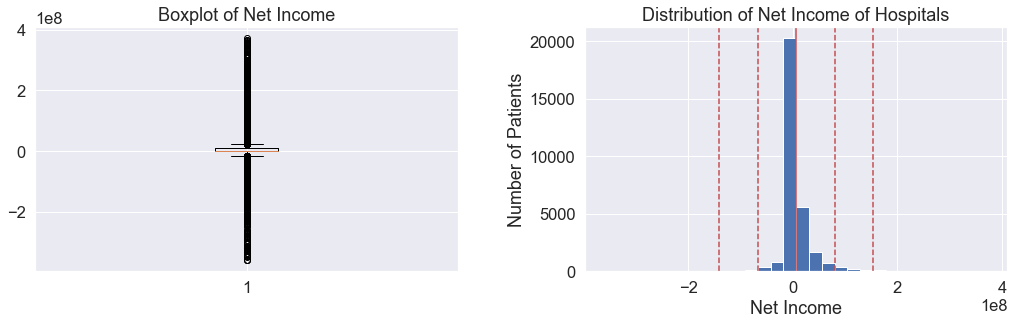

In [39]:
# Plot the new boxplot and histogram for Net Income.

fig, axs = plt.subplots(1,2, figsize=(15,4))

# Boxplot of Net Income
axs[0].boxplot(hosp_final_z['Net Income-L10'])
axs[0].set_title('Boxplot of Net Income')

# Histogram of Net Income
axs[1].hist(hosp_final_z['Net Income-L10'], bins=30)
_ = plt.xlabel('Net Income')
_ = plt.ylabel('Number of Patients')
_ = plt.title('Distribution of Net Income of Hospitals')
_ = plt.axvline(np.mean(net_income),color='r')
_ = plt.axvline(np.mean(net_income) + np.std(net_income), color='r', linestyle='--')
_ = plt.axvline(np.mean(net_income) - np.std(net_income), color='r', linestyle='--')
_ = plt.axvline(np.mean(net_income) + (2*np.std(net_income)), color='r', linestyle='--')
_ = plt.axvline(np.mean(net_income) - (2*np.std(net_income)), color='r', linestyle='--')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

plt.show()

The boxplot and histogram look a little cleaner, with the box and bins becoming more evident. Though they are very narrow, the boxplot looks relatively symmetric while the histogram seems to follow some form of the normal distribution. To verify the normal distribution, we'll use `normaltest()`.

In [40]:
print(stats.normaltest(hosp_final_z['Net Income-L10']))

NormaltestResult(statistic=13928.74842402754, pvalue=0.0)


Since the p-value from the `normaltest()` is zero, the distribution of Net Income is significantly normal.

### Features and Correlations

Next, we'll look into the possible features that may have some correlation with Net Income. Let's first identify the ones that are continuous (at least not discrete), then analyze their correlations with each other and particularly with Net Income.

In [41]:
# Print the columns.
# print(hosp_final.dtypes)

In [42]:
# Find columns that are not discrete and also of numeric type.

cont_list = [] # Continuous list. Or rather not disrete.
for col in hosp_final.columns.values.tolist():
    if (len(hosp_final[col].value_counts()) > 2) & (is_numeric_dtype(hosp_final[col])) & \
                          (col not in ['rpt_rec_num','Provider CCN','Type of Control','Provider Type']):
        cont_list.append(col)


In [43]:
# Find columns in the original but not in the continuous list.
print(set(hosp_final.columns.values.tolist()) - set(cont_list))

{'Net Revenue from Stand-Alone SCHIP-HIGH', 'Deferred Income-HIGH', 'Zip Code', 'Hospital Name', 'rpt_rec_num', 'Provider CCN', 'City', 'Mortgage Payable-HIGH', 'CCN Facility Type', 'Wage Related Costs for Part - A Teaching Physicians-HIGH', 'Minor Equipment Depreciable-HIGH', 'County', 'Street Address', 'Fiscal Year Begin Date', 'Fiscal Year End Date', 'State Code', 'Stand-Alone SCHIP Charges-HIGH', 'Wage Related Costs for Interns and Residents-HIGH', 'Data_Year', 'Provider Type', 'Type of Control', 'Total IME Payment-HIGH'}


We'll use the the columns in `cont_list` to see how the correlations map with each other.

In [44]:
# Filter the dataset with the new columns
hosp_final_zf = hosp_final_z[[i for i in cont_list]]

In [45]:
# Correlations of all columns with Net Income
hosp_final_zf_corr = hosp_final_zf.corr().loc[:,['Net Income-L10']].sort_values('Net Income-L10',ascending=False)
hosp_final_zf_corr

,Net Income-L10
Net Income-L10,1.000000
Total Income-L10,0.929022
Net Patient Revenue-L10,0.574391
Gross Revenue-L10,0.542483
Combined Outpatient + Inpatient Total Charges-L10,0.534734
Outpatient Revenue-LOW,0.534341
Outpatient Total Charges-L10,0.532352
Inpatient Revenue-L10,0.515782
Less Contractual Allowance and discounts on patients' accounts-L10,0.511456
Inpatient Total Charges-L10,0.510363


The top two features with very high correlations - Net Income and Total Income - have obvious reasons for the high values. We'll ignore these. For the other columns, there are quite a few with correlations that have an absolute value of at least 0.50. Let's arbitrarily pick these columns to analyze.

In [46]:
# # Remove the top 2 correlated columns.
# if ('Net Income-L10','Total Income-L10') in hosp_final_zf_corr.index.values.tolist():
#     hosp_final_zf_corr.drop(['Net Income-L10','Total Income-L10'], axis=0, inplace=True)
# hosp_final_zf_2 = hosp_final_zf[[i for i in int_col]]

# Only choose features that have absolute value of at least 0.50
hosp_corr_5 = hosp_final_zf_corr[(hosp_final_zf_corr['Net Income-L10'] > 0.5)].index.values.tolist()
hosp_corr_final = hosp_final_zf[[i for i in hosp_corr_5]]
hosp_corr_final.head()

,Net Income-L10,Total Income-L10,Net Patient Revenue-L10,Gross Revenue-L10,Combined Outpatient + Inpatient Total Charges-L10,Outpatient Revenue-LOW,Outpatient Total Charges-L10,Inpatient Revenue-L10,Less Contractual Allowance and discounts on patients' accounts-L10,Inpatient Total Charges-L10,Total Discharges (V + XVIII + XIX + Unknown)-L10,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds-L10,Total Discharges (V + XVIII + XIX + Unknown) + Total for all Subproviders-L10,Total Costs-L10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-4847519.0,-4847519.0,32129497.0,129652291.0,129652291.0,45909263.0,45594791.0,83743028.0,97522794.0,84057500.0,2873.0,2873.0,2873.0,74298056.0
3,1227980.0,1227980.0,13305420.0,45061301.0,43936576.0,26466851.0,26435402.0,18594450.0,31755881.0,17501174.0,882.0,882.0,882.0,13907419.0
4,-41490162.0,-41490162.0,0.0,0.0,25000.0,0.0,11000.0,0.0,0.0,14000.0,3867.0,3867.0,3867.0,44926120.0


Let's now visualize the correlations of this new dataframe.

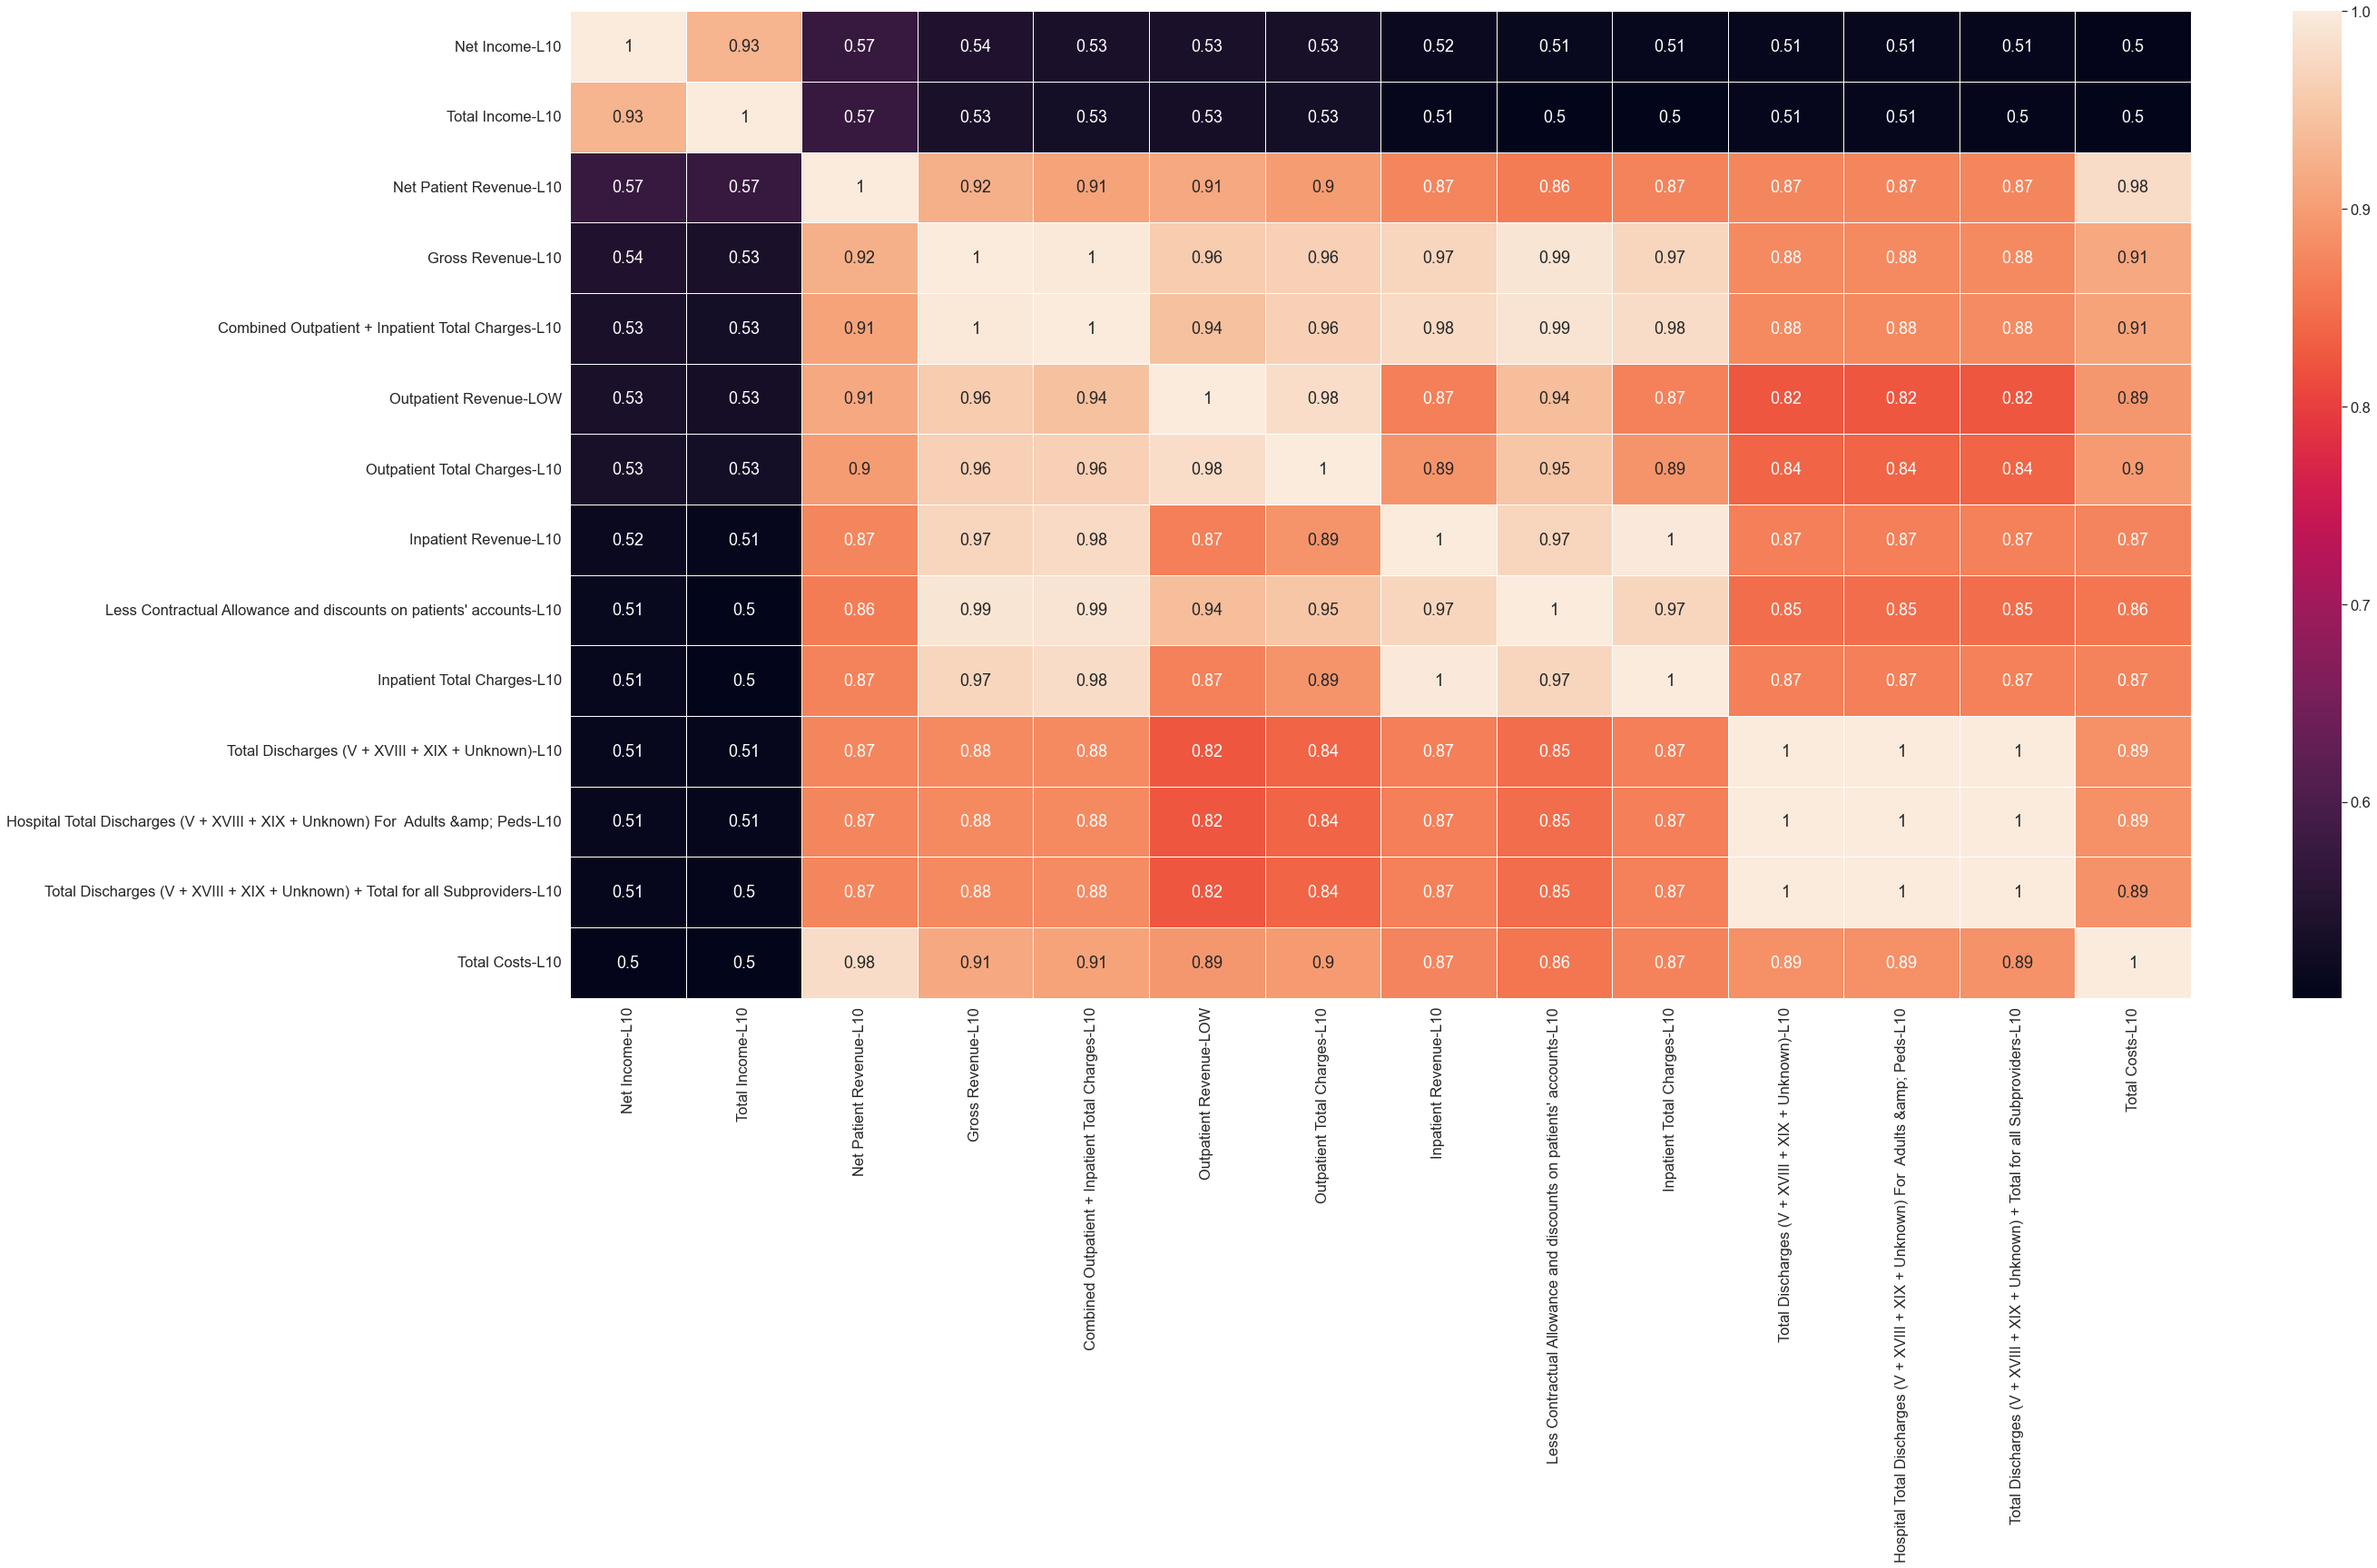

In [47]:
# Make a heatmap of the data
plt.figure(figsize=(40,20))
sns.heatmap(hosp_corr_final.corr(), linewidths=0.5, annot=True)
plt.show()

In [48]:
# # Make a heatmap of the data for only Net Income
# plt.figure(figsize=(40,20))
# sns.heatmap(hosp_corr_final.corr().loc[:,['Net Income-L10']], linewidths=0.5, annot=True)
# plt.show()

From the above heatmap, there are several perfectly correlated variables:

- `Total Discharges (V + XVIII + XIX + Unknown)-L10`, 
`Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds-L10`, and `Total Discharges (V + XVIII + XIX + Unknown) + Total for all Subproviders-L10` are perfectly correlated with each other, which would make all three redundant. 
    - We'll randomly choose the first one for the analysis.
- `Inpatient Revenue-L10` and `Inpatient Total Charges-L10` are perfectly correlated. 
    - We'll choose the former one due to slightly higher correlation.
- `Gross Revenue-L10` is perfectly correlated with `Combined Outpatient + Inpatient Total Charges-L10`.
    - We'll choose the former.
 
Notably, there are several very highly correlated variables ( >0.95). We'll drop `Total Income-L10` due to very high correlation with our dependent varible, but we'll keep others for now.

In [63]:
# Update dataset by dropping the perfectly correlated variables.

drop_list = ['Total Income-L10',
             'Hospital Total Discharges (V + XVIII + XIX + Unknown) For  Adults &amp; Peds-L10',
             'Total Discharges (V + XVIII + XIX + Unknown) + Total for all Subproviders-L10',
             'Inpatient Total Charges-L10',
             'Combined Outpatient + Inpatient Total Charges-L10']

hosp_corr_final2 = hosp_corr_final.copy()
for i in drop_list:
    if i in hosp_corr_final2.columns.values.tolist():
        hosp_corr_final2.drop(i, axis=1, inplace=True)
        

Let's run the heatmap again with the updated dataframe.

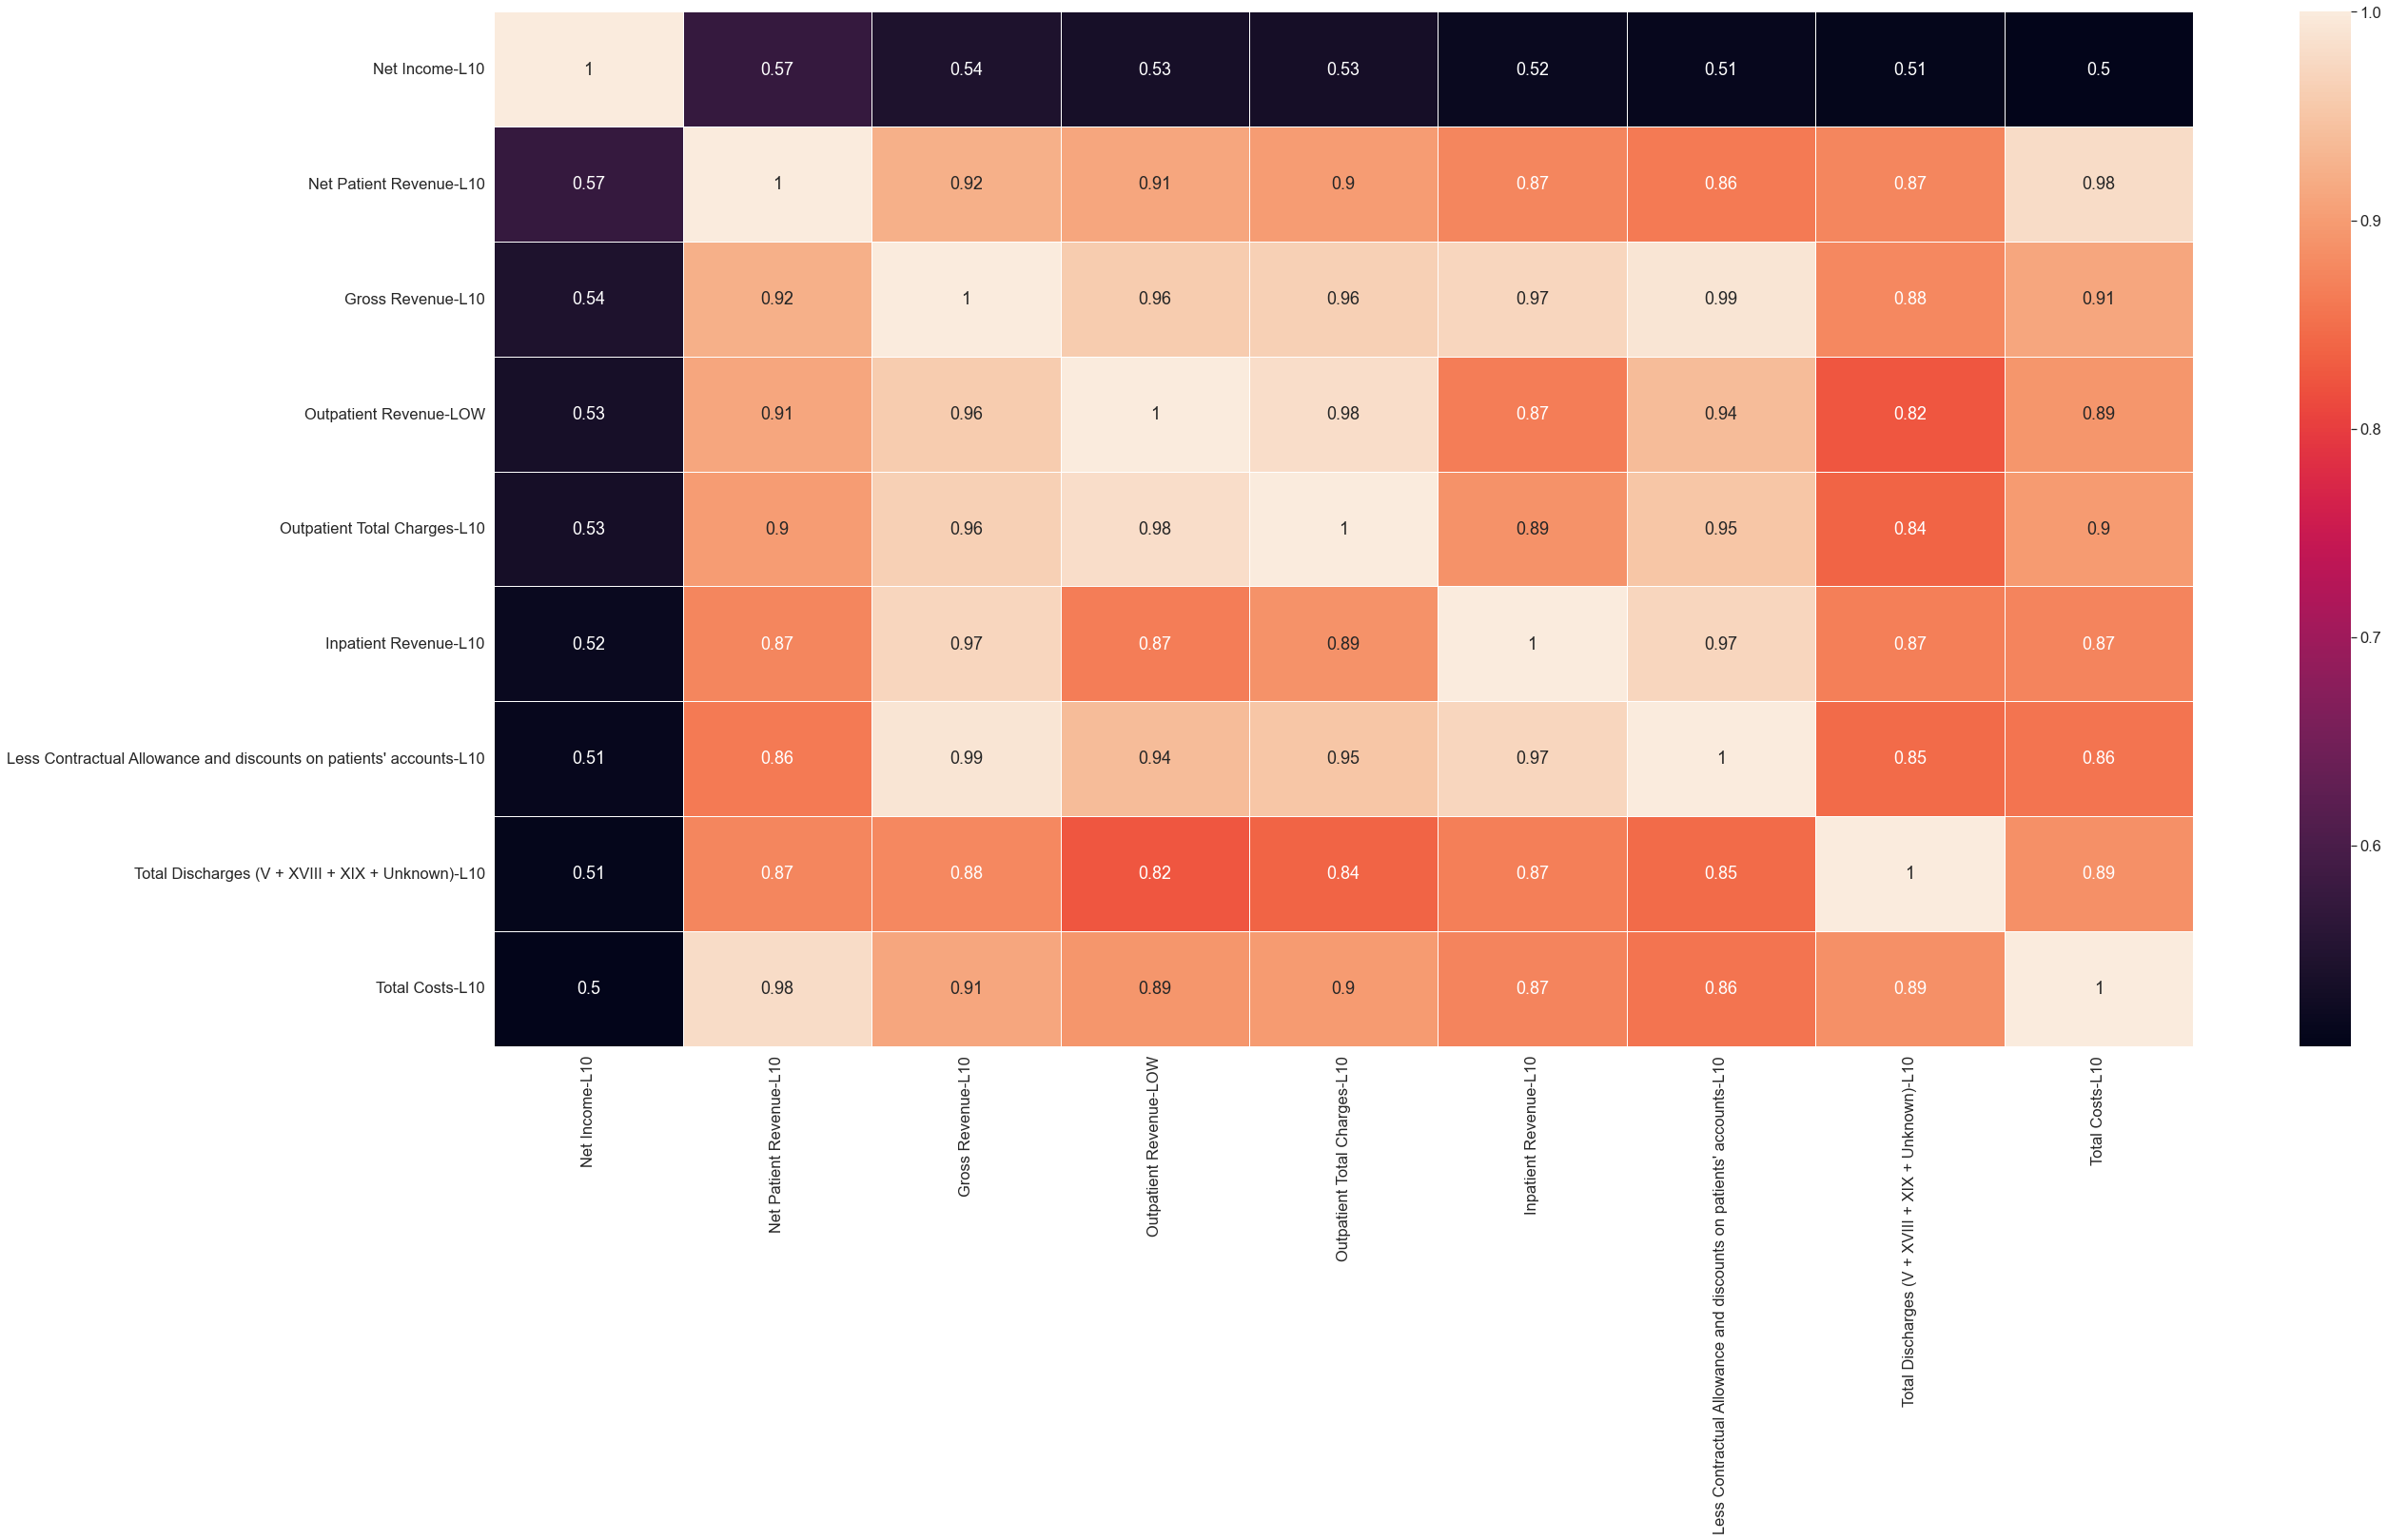

In [65]:
# Make a heatmap of the data
plt.figure(figsize=(40,20))
sns.heatmap(hosp_corr_final2.corr(), linewidths=0.5, annot=True)
plt.show()

One possible issue is that almost all the variables are in some way correlated with each other. Notice that the dark (black) color represents the lower end which is still at least 0.5 correlation. Only the dependent variable `Net Income-L10` contains these lower correlations; all other variables are in some way positively correlated (Remember that the negative correlations don't show because none of the variables had an absolute value greater than 0.50).

Regardless, we'll use this final dataset for our modelling.

In [66]:
hosp = hosp_corr_final2.copy()